# How to further train a pre-trained model

We will demonstrate how to freeze some or all of the layers of a pre-trained model and continue training using a new fully-connected set of layers and data with a different format. 

Adapted from the Tensorflow 2.0 [transfer learning tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning).

## Imports & Settings

In [1]:
%matplotlib inline

from sklearn.datasets import load_files       
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

import tensorflow_datasets as tfds

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
results_path = Path('results', 'transfer_learning')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [4]:
sns.set_style('whitegrid')

## Load TensorFlow Cats vs Dog Dataset

TensorFlow includes a large number of built-in dataset:

In [5]:
tfds.list_builders()

['abstract_reasoning',
 'aflw2k3d',
 'amazon_us_reviews',
 'bair_robot_pushing_small',
 'bigearthnet',
 'binarized_mnist',
 'binary_alpha_digits',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_corrupted',
 'clevr',
 'cnn_dailymail',
 'coco',
 'coco2014',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'eurosat',
 'fashion_mnist',
 'flores',
 'food101',
 'gap',
 'glue',
 'groove',
 'higgs',
 'horses_or_humans',
 'image_label_folder',
 'imagenet2012',
 'imagenet2012_corrupted',
 'imdb_reviews',
 'iris',
 'kitti',
 'kmnist',
 'lfw',
 'lm1b',
 'lsun',
 'mnist',
 'mnist_corrupted',
 'moving_mnist',
 'multi_nli',
 'nsynth',
 'omniglot',

We will use a set of cats and dog images for binary classification.

In [6]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=[
        tfds.Split.TRAIN.subsplit(tfds.percent[:80]),
        tfds.Split.TRAIN.subsplit(tfds.percent[80:90]),
        tfds.Split.TRAIN.subsplit(tfds.percent[90:])
    ],
    with_info=True,
    as_supervised=True,
    data_dir='../data/tensorflow'
)

In [7]:
print('Raw train:\t', raw_train)
print('Raw validation:\t', raw_validation)
print('Raw test:\t', raw_test)

Raw train:	 <_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
Raw validation:	 <_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
Raw test:	 <_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


### Show sample images

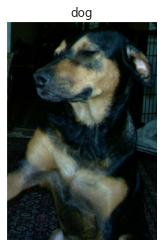

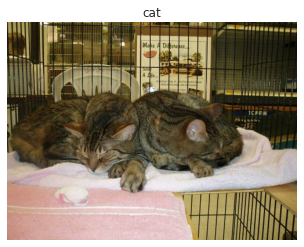

In [8]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))
    plt.grid(False)
    plt.axis('off')

## Preprocessing

All images will be resized to 160x160:

In [9]:
IMG_SIZE = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [10]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [11]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [12]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [13]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [14]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 160, 160, 3])

## Load the VGG-16 Bottleneck Features

We use the VGG16 weights, pre-trained on ImageNet with the much smaller 32 x 32 CIFAR10 data. Note that we indicate the new input size upon import and set all layers to not trainable:

In [15]:
vgg16 = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [16]:
feature_batch = vgg16(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

## Freeze model layers

In [17]:
vgg16.trainable = False

In [18]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

## Add new layers to model

### Using the Sequential model API

In [19]:
global_average_layer = GlobalAveragePooling2D()
dense_layer = Dense(64, activation='relu')
dropout = Dropout(0.5)
prediction_layer = Dense(1, activation='sigmoid')

In [20]:
seq_model = tf.keras.Sequential([vgg16, 
                                 global_average_layer, 
                                 dense_layer, 
                                 dropout, 
                                 prediction_layer])

In [21]:
seq_model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                       optimizer = 'Adam', 
                       metrics=["accuracy"])

In [22]:
seq_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                32832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 14,747,585
Trainable params: 32,897
Non-trainable params: 14,714,688
_________________________________________________________________


### Using the Functional model API

We use Keras’ functional API to define the vgg16 output as input into a new set of fully-connected layers like so:

In [23]:
#Adding custom Layers 
x = vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

We define a new model in terms of inputs and output, and proceed from there on as before:

In [24]:
transfer_model = Model(inputs = vgg16.input, 
                       outputs = predictions)

In [25]:
transfer_model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                       optimizer = 'Adam', 
                       metrics=["accuracy"])

In [26]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

### Compute baseline metrics

In [27]:
initial_epochs = 10
validation_steps=20

initial_loss, initial_accuracy = transfer_model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 1s 39ms/step - loss: 0.7047 - accuracy: 0.5125


In [28]:
print(f'Initial loss: {initial_loss:.2f} | initial_accuracy accuracy: {initial_accuracy:.2%}')

Initial loss: 0.70 | initial_accuracy accuracy: 51.25%


## Train VGG16 transfer model

In [29]:
history = transfer_model.fit(train_batches,
                             epochs=initial_epochs,
                             validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 66s 114ms/step - loss: 0.5639 - accuracy: 0.8729 - val_loss: 0.5465 - val_accuracy: 0.9371
Epoch 2/10
582/582 [==============================] - 57s 97ms/step - loss: 0.5384 - accuracy: 0.9260 - val_loss: 0.5424 - val_accuracy: 0.9409
Epoch 3/10
582/582 [==============================] - 53s 92ms/step - loss: 0.5346 - accuracy: 0.9323 - val_loss: 0.5399 - val_accuracy: 0.9362
Epoch 4/10
582/582 [==============================] - 51s 87ms/step - loss: 0.5331 - accuracy: 0.9359 - val_loss: 0.5394 - val_accuracy: 0.9444
Epoch 5/10
582/582 [==============================] - 48s 82ms/step - loss: 0.5316 - accuracy: 0.9378 - val_loss: 0.5388 - val_accuracy: 0.9345
Epoch 6/10
582/582 [==============================] - 48s 82ms/step - loss: 0.5308 - accuracy: 0.9397 - val_loss: 0.5380 - val_accuracy: 0.9401
Epoch 7/10
582/582 [==============================] - 60s 104ms/step - loss: 0.5305 - accuracy: 0.9399 - val_loss: 0.5391 - val_accurac

### Plot Learning Curves

In [30]:
def plot_learning_curves(df):
    fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
    df[['loss', 'val_loss']].plot(ax=axes[0], title='Cross-Entropy')
    df[['accuracy', 'val_accuracy']].plot(ax=axes[1], title='Accuracy')
    for ax in axes:
        ax.legend(['Training', 'Validation'])
    sns.despine()        
    fig.tight_layout();

In [31]:
metrics = pd.DataFrame(history.history)

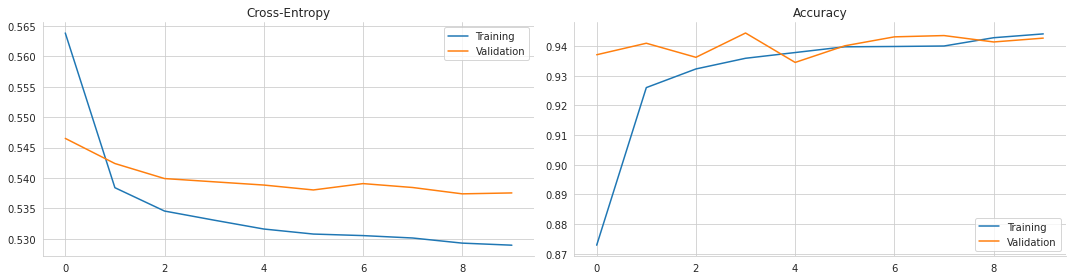

In [32]:
plot_learning_curves(metrics)

## Fine-tune VGG16 weights

### Unfreeze selected layers

In [33]:
vgg16.trainable = True

How many layers are in the base model:

In [34]:
f'Number of layers in the base model: {len(vgg16.layers)}'

'Number of layers in the base model: 19'

In [35]:
# Fine-tune from this layer onwards
start_fine_tuning_at = 12

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg16.layers[:start_fine_tuning_at]:
    layer.trainable =  False

In [36]:
base_learning_rate = 0.0001
transfer_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate / 10),
    metrics=['accuracy'])

### Define callbacks

In [37]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

In [38]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

### Continue Training

And now we proceed to train the model:

In [39]:
fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

history_fine_tune = transfer_model.fit(train_batches,
                                       epochs=total_epochs,
                                       initial_epoch=history.epoch[-1],
                                       validation_data=validation_batches,
                                       callbacks=[early_stopping])

Epoch 10/60
582/582 [==============================] - 52s 90ms/step - loss: 0.5276 - accuracy: 0.9480 - val_loss: 0.5346 - val_accuracy: 0.9414
Epoch 11/60
582/582 [==============================] - 52s 90ms/step - loss: 0.5195 - accuracy: 0.9660 - val_loss: 0.5320 - val_accuracy: 0.9453
Epoch 12/60
582/582 [==============================] - 53s 91ms/step - loss: 0.5162 - accuracy: 0.9723 - val_loss: 0.5247 - val_accuracy: 0.9711
Epoch 13/60
582/582 [==============================] - 53s 90ms/step - loss: 0.5136 - accuracy: 0.9785 - val_loss: 0.5233 - val_accuracy: 0.9746
Epoch 14/60
582/582 [==============================] - 53s 91ms/step - loss: 0.5114 - accuracy: 0.9834 - val_loss: 0.5245 - val_accuracy: 0.9690
Epoch 15/60
582/582 [==============================] - 52s 89ms/step - loss: 0.5094 - accuracy: 0.9872 - val_loss: 0.5234 - val_accuracy: 0.9763
Epoch 16/60
582/582 [==============================] - 52s 89ms/step - loss: 0.5085 - accuracy: 0.9895 - val_loss: 0.5225 - val_ac

In [40]:
metrics_tuned = metrics.append(pd.DataFrame(history_fine_tune.history), ignore_index=True)

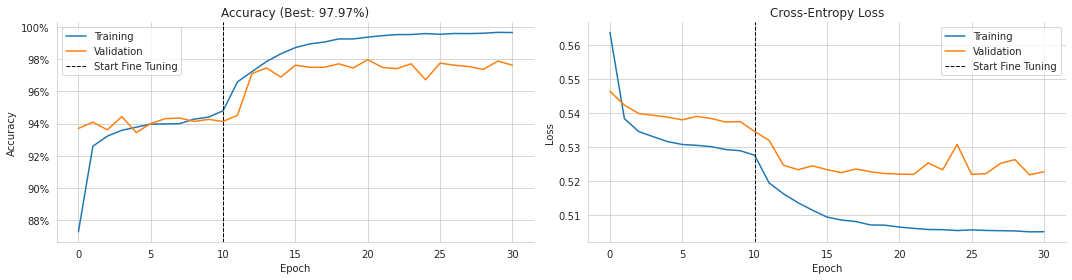

In [41]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
metrics_tuned[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy Loss')
metrics_tuned[['accuracy', 'val_accuracy']].plot(ax=axes[0], title=f'Accuracy (Best: {metrics_tuned.val_accuracy.max():.2%})')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('Loss')
for ax in axes:
    ax.axvline(10, ls='--', lw=1, c='k')
    ax.legend(['Training', 'Validation', 'Start Fine Tuning'])
    ax.set_xlabel('Epoch')
sns.despine()    
fig.tight_layout()
fig.savefig(results_path / 'transfer_learning');